## 复现 PyTorch 中的 affine_grid 和 grid_sample

grid = torch.nn.functional.affine_grid(theta, size)

outputs = torch.nn.functional.grid_sample(inputs, grid, mode='bilinear')

In [7]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import functional as F
import math

%matplotlib inline

### 原图展示

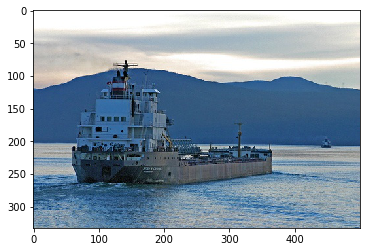

In [8]:
fpath_img = "./images/000154.jpg"
img = transforms.ToTensor()(Image.open(fpath_img)).unsqueeze(0)  # img: (1, 3, 333, 500)

plt.imshow(img.squeeze().numpy().transpose(1,2,0))

In [13]:
def my_affine_grid(theta, size):
    """
    theta:           [N,2,3], float
    size:            means [N,C,H,W] 
    
    return grid:     [N,H,W,2], float
    """
    
    N = size[0]
    H = size[2]
    W = size[3]
    
    grid = torch.zeros((N, H, W, 2), dtype=torch.float)

    x_list = torch.arange(W, dtype=torch.float)
    y_list = torch.arange(H, dtype=torch.float)
    
    # turn [0,H/W] to [-1,1]
    x_list = (x_list + 1) / W * 2 -1
    y_list = (y_list + 1) / H * 2 -1
    
    
    for y in range(H):
        for x in range(W):
            dy = y_list[y]
            dx = x_list[x]
            dz = torch.tensor(1, dtype=torch.float).reshape(1)
            
            
            loc = torch.cat([dx.reshape(1), dy.reshape(1), dz], 0)
            tx = (theta[0, 0] * loc).sum()
            ty = (theta[0, 1] * loc).sum()

            grid[0, y, x, 0] = tx
            grid[0, y, x, 1] = ty
            
    return grid


def my_bilinear(x, y, img):
    im = img[0]
    
    x1 = int(x)
    x2 = x1 + 1
    y1 = int(y)
    y2 = y1 + 1    
    
    q12 = im[:,y2,x1]
    q22 = im[:,y2,x2]
    q11 = im[:,y1,x1]
    q21 = im[:,y1,x2]
    
    r1 = (x2-x)/(x2-x1)*q11 + (x-x1)/(x2-x1)*q21
    r2 = (x2-x)/(x2-x1)*q12 + (x-x1)/(x2-x1)*q22
    p = (y2-y)/(y2-y1)*r1 + (y-y1)/(y2-y1)*r2
    
    return p


def my_grid_sample(img, grid):
    my_out = torch.zeros(img.size(), dtype=torch.float)

    H = img.size()[2]
    W = img.size()[3]
    for y in range(H):
        for x in range(W):
            loc_pixel = grid[0,y,x,:]    
            img_x = (loc_pixel[0] + 1) / 2 * W
            img_y = (loc_pixel[1] + 1) / 2 * H

            if img_x < 0 or img_x + 1 >= W or img_y < 0 or img_y + 1 >= H:
                pixel = torch.tensor([0,0,0])
            else:
                pixel =  my_bilinear(img_x, img_y, img)

            my_out[0,:,y,x] = pixel
            
    return my_out

### theta 设定

In [10]:
# theta = torch.tensor([
#     [0.5, 0, -1],
#     [0, 0.5, 0.5]
# ], dtype=torch.float).unsqueeze(0)       # (1,2,3)

angle = -40*math.pi/180
theta = torch.tensor([
    [math.cos(angle),math.sin(-angle),0],
    [math.sin(angle),math.cos(angle) ,0]
], dtype=torch.float).unsqueeze(0)

### 官方实现

img:torch.Size([1, 3, 333, 500])
theta:torch.Size([1, 2, 3])
grid:torch.Size([1, 333, 500, 2])
output:torch.Size([1, 3, 333, 500])


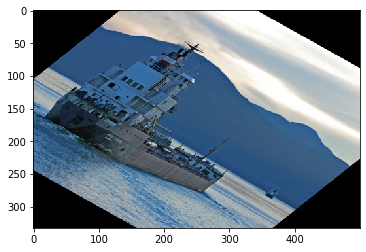

In [11]:
grid = F.affine_grid(theta, img.size())  # (1,333,500,2)
output = F.grid_sample(img, grid)        # (1,3,333,500)

plt.imshow(output.squeeze().numpy().transpose(1,2,0))
print('img:{}\ntheta:{}\ngrid:{}\noutput:{}'.format(img.size(), theta.size(), grid.size(), output.size()))

### 自己的粗糙实现

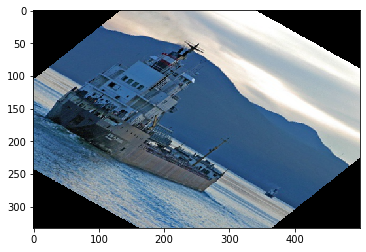

In [14]:
my_grid = my_affine_grid(theta, img.size())
my_out = my_grid_sample(img, grid)
plt.imshow(my_out.squeeze().numpy().transpose(1,2,0))